<a href="https://colab.research.google.com/github/Nilufayeasmin299/Reproduce-GNN_Ownership_Verification/blob/main/Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio torch-geometric numpy scikit-learn tqdm matplotlib



In [13]:
# Import Libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid, Amazon
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm



In [14]:
def create_masks(data, train_ratio=0.6, val_ratio=0.2):
    """
    Create train, validation, and test masks for datasets.
    """
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)  # Randomly shuffle nodes
    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    # Initialize masks
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Assign indices
    data.train_mask[indices[:train_size]] = True
    data.val_mask[indices[train_size:train_size + val_size]] = True
    data.test_mask[indices[train_size + val_size:]] = True

    return data


In [15]:
# Load Datasets
DATASETS = {
    'Cora': Planetoid(root='/tmp/Cora', name='Cora'),
    'CiteSeer': Planetoid(root='/tmp/CiteSeer', name='CiteSeer'),
    'Amazon': Amazon(root='/tmp/Amazon', name='Photo'),
    'PubMed': Planetoid(root='/tmp/PubMed', name='PubMed')
}

# Ensure Masks Exist and Update DATASETS
for dataset_name, dataset in DATASETS.items():
    data = dataset[0]
    print(f"Dataset: {dataset_name}")
    if not hasattr(data, 'train_mask') or not hasattr(data, 'val_mask') or not hasattr(data, 'test_mask'):
        print(f"Creating masks for {dataset_name}...")
        data = create_masks(data)
        # Update the dataset in DATASETS with the modified data object
        dataset.data = data #This line is added
        DATASETS[dataset_name] = dataset#This line is added
    print(f"Masks for {dataset_name}:")
    print(f"Train Mask Exists: {hasattr(data, 'train_mask')}")
    print(f"Validation Mask Exists: {hasattr(data, 'val_mask')}")
    print(f"Test Mask Exists: {hasattr(data, 'test_mask')}")


Dataset: Cora
Masks for Cora:
Train Mask Exists: True
Validation Mask Exists: True
Test Mask Exists: True
Dataset: CiteSeer
Masks for CiteSeer:
Train Mask Exists: True
Validation Mask Exists: True
Test Mask Exists: True
Dataset: Amazon
Creating masks for Amazon...
Masks for Amazon:
Train Mask Exists: True
Validation Mask Exists: True
Test Mask Exists: True
Dataset: PubMed
Masks for PubMed:
Train Mask Exists: True
Validation Mask Exists: True
Test Mask Exists: True


In [16]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, model_type='gcn'):
        """
        General GNN architecture supporting GCN, GAT, and GraphSAGE.
        """
        super(GNN, self).__init__()
        if model_type == 'gcn':
            self.conv1 = GCNConv(in_channels, 64)
            self.conv2 = GCNConv(64, out_channels)
        elif model_type == 'gat':
            self.conv1 = GATConv(in_channels, 64, heads=8, concat=True)
            self.conv2 = GATConv(64 * 8, out_channels, heads=1, concat=False)
        elif model_type == 'sage':
            self.conv1 = SAGEConv(in_channels, 64)
            self.conv2 = SAGEConv(64, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [17]:
def train_gnn(model, data, optimizer, criterion):
    """
    Train a GNN model on the dataset using the given optimizer and criterion.
    """
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gnn(model, data):
    """
    Evaluate a GNN model on the dataset.
    """
    model.eval()
    _, pred = model(data).max(dim=1)
    true_labels = data.y[data.test_mask].cpu()
    pred_labels = pred[data.test_mask].cpu()

    # Accuracy
    acc = accuracy_score(true_labels, pred_labels)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    # Class-Wise Metrics
    fpr = 1 - np.diag(conf_matrix) / conf_matrix.sum(axis=1)
    fnr = 1 - np.diag(conf_matrix) / conf_matrix.sum(axis=0)

    # Average Metrics
    avg_fpr = np.mean(fpr)
    avg_fnr = np.mean(fnr)

    return acc, avg_fpr, avg_fnr


In [18]:
MASK_RATIOS = [0.0, 0.05, 0.1, 0.2, 0.4]
GNN_MODELS = ['gcn', 'gat', 'sage']
RESULTS = {}

# Run Experiments
for dataset_name, dataset in tqdm(DATASETS.items(), desc="Running Experiments"):
    data = dataset[0]
    in_channels = data.num_features
    out_channels = dataset.num_classes

    for model_type in GNN_MODELS:
        gnn_model = GNN(in_channels, out_channels, model_type).to('cuda' if torch.cuda.is_available() else 'cpu')
        data = data.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=1e-4)
        criterion_gnn = torch.nn.CrossEntropyLoss()

        # Train GNN Model
        for epoch in range(100):
            loss = train_gnn(gnn_model, data, optimizer_gnn, criterion_gnn)

        # Evaluate GNN Model
        gnn_acc, gnn_fpr, gnn_fnr = evaluate_gnn(gnn_model, data)

        # Record Results
        RESULTS[f"{dataset_name}_{model_type}"] = {
            'GNN_ACC': gnn_acc, 'GNN_FPR': gnn_fpr, 'GNN_FNR': gnn_fnr
        }
        print(f"Dataset: {dataset_name} | Model: {model_type} | "
              f"ACC: {gnn_acc:.4f} | FPR: {gnn_fpr:.4f} | FNR: {gnn_fnr:.4f}")


Running Experiments:   0%|          | 0/4 [00:00<?, ?it/s]

Dataset: Cora | Model: gcn | ACC: 0.7910 | FPR: 0.1864 | FNR: 0.2316
Dataset: Cora | Model: gat | ACC: 0.7930 | FPR: 0.1835 | FNR: 0.2310


Running Experiments:  25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

Dataset: Cora | Model: sage | ACC: 0.7620 | FPR: 0.2101 | FNR: 0.2445
Dataset: CiteSeer | Model: gcn | ACC: 0.6810 | FPR: 0.3353 | FNR: 0.3348
Dataset: CiteSeer | Model: gat | ACC: 0.6420 | FPR: 0.3938 | FNR: 0.3857


Running Experiments:  50%|█████     | 2/4 [00:04<00:04,  2.04s/it]

Dataset: CiteSeer | Model: sage | ACC: 0.7020 | FPR: 0.3387 | FNR: 0.3233
Dataset: Amazon | Model: gcn | ACC: 0.9235 | FPR: 0.1103 | FNR: 0.0715
Dataset: Amazon | Model: gat | ACC: 0.9327 | FPR: 0.0774 | FNR: 0.0675


Running Experiments:  75%|███████▌  | 3/4 [00:10<00:04,  4.25s/it]

Dataset: Amazon | Model: sage | ACC: 0.9229 | FPR: 0.1122 | FNR: 0.0737
Dataset: PubMed | Model: gcn | ACC: 0.7760 | FPR: 0.2198 | FNR: 0.2303
Dataset: PubMed | Model: gat | ACC: 0.7670 | FPR: 0.2478 | FNR: 0.2364


Running Experiments: 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

Dataset: PubMed | Model: sage | ACC: 0.7590 | FPR: 0.2417 | FNR: 0.2446


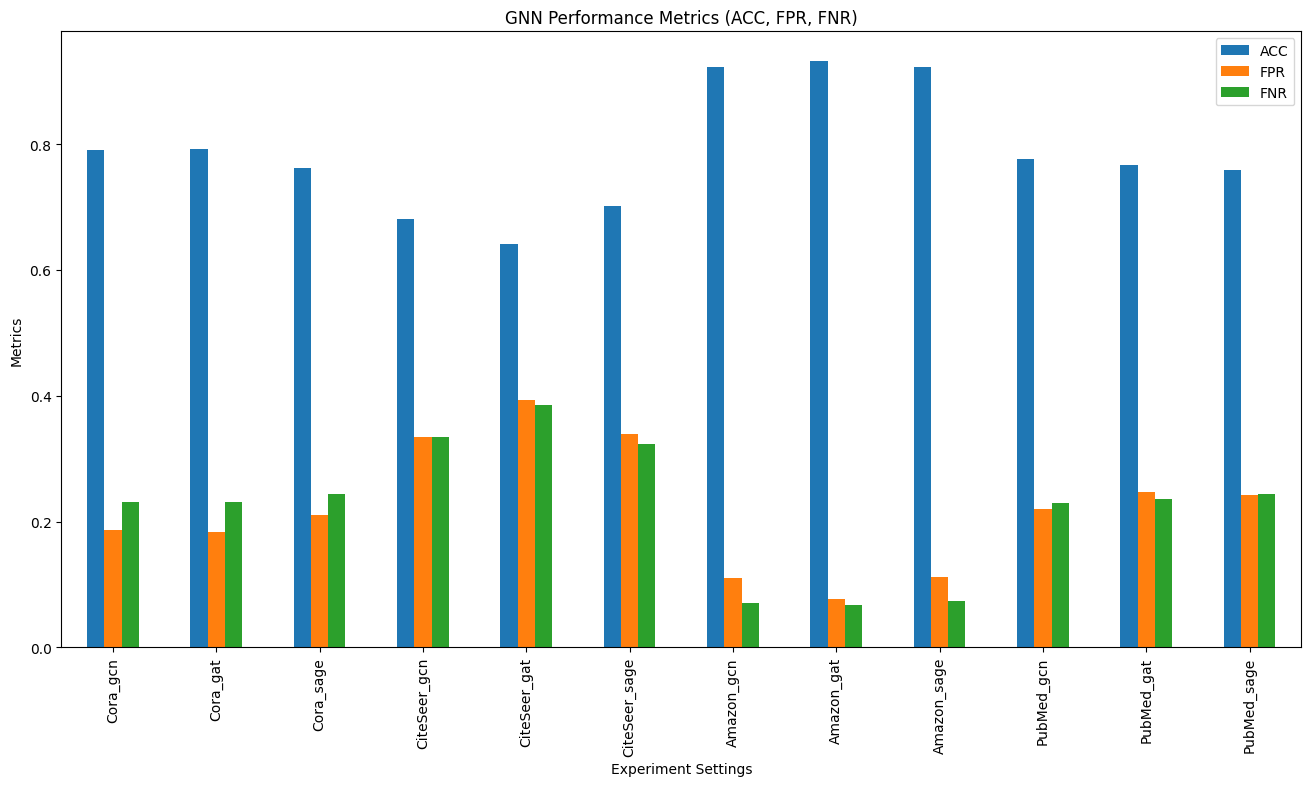

In [19]:
# Visualize Results
result_df = pd.DataFrame.from_dict(RESULTS, orient='index')
result_df.style.format("{:.4f}")

result_df.plot(kind='bar', figsize=(16, 8))
plt.title("GNN Performance Metrics (ACC, FPR, FNR)")
plt.xlabel("Experiment Settings")
plt.ylabel("Metrics")
plt.legend(["ACC", "FPR", "FNR"])
plt.show()
